# Originalmodellen även med test av liten augmentering av datat

In [3]:
#Paket importeras 
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import random
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

# Displaying Images

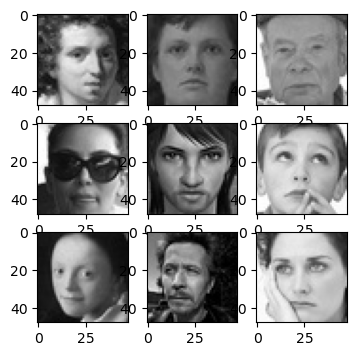

In [9]:
# endast mini EDA här för att få känsla
picture_size = 48
folder_path = r'C:\Users\Daniel\Documents\ec_utbildning\DL\Kunskapskontroll\images\images'   
expression = 'neutral'

plt.figure(figsize=(4, 4))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    img = load_img(os.path.join(folder_path, "train", expression, 
                                 os.listdir(os.path.join(folder_path, "train", expression))[i - 1]), 
                   target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Originalmodellen 

In [ ]:
# Modellbygge med hög enkelhet och låg komplexitet som ledstjärna detta är utgångsläget med högst komplexitet sedan 
# kommer simplifiering i linje med "Occams razor" tillämpas. Bakgrundstänket är att skapa modell som kräver minimal datorkraft 
# och samtidigt kan uppnå en rimlig "explainability" (XAI -explainable AI). Validation accuracy runt 0,85-0,9 i en 
# klassificering med dessa 7 klasser ska uppnås på enklast möjliga vis, målet är inte att skapa maximal validation accuracy.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax')
])

# Callbacks
checkpoint = ModelCheckpoint("./modelskarp3.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# kompilering  mindre lerarning rate testades men ingen förbättring 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Fit av originalmodellen

In [10]:
# Data prepp med sets som är reducerade maximalt för att ändå uppnå målet i validation accuracy. (>0,85)
picture_size = 48
folder_path = r'C:\Users\Daniel\Documents\ec_utbildning\DL\Kunskapskontroll\images\images'
batch_size = 128
epochs = 25  

# Skalning
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

# dataflowgeneratorer
train_generator = datagen_train.flow_from_directory(os.path.join(folder_path, "train_mini"),
                                                    target_size=(picture_size, picture_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_val.flow_from_directory(os.path.join(folder_path, "validation_mini"),
                                                       target_size=(picture_size, picture_size),
                                                       color_mode="grayscale",
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       shuffle=False)

# Skapa TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32))
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32))
)

# repeat metoden
train_dataset = train_dataset.repeat()
validation_dataset = validation_dataset.repeat()

# optimering genom att förhämta data
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# beräknar epoksteg och valideringssteg
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

# Träning
historyskarp3 = model.fit(x=train_dataset,
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         validation_data=validation_dataset,
                         validation_steps=validation_steps,
                         callbacks=callbacks_list)

# Sparar träningshistorik
with open('historyskarp3.pkl', 'wb') as file:
    pickle.dump(historyskarp3.history, file)

Found 6750 images belonging to 7 classes.
Found 3582 images belonging to 7 classes.
Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.2114 - loss: 1.8517
Epoch 1: val_accuracy improved from -inf to 0.24016, saving model to ./modelskarp3.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.2117 - loss: 1.8513 - val_accuracy: 0.2402 - val_loss: 1.8240 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2877 - loss: 1.7549
Epoch 2: val_accuracy improved from 0.24016 to 0.33874, saving model to ./modelskarp3.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.2880 - loss: 1.7545 - val_accuracy: 0.3387 - val_loss: 1.6740 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3674 - loss: 1.6254
Epoch 3: val_accuracy improved from 0.33874 to 0.37406, saving model to ./modelskarp3.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.3676 - loss: 1.6252 - val_accuracy: 0.3741 - val_

Epoch 22/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9318 - loss: 0.2258
Epoch 22: val_accuracy improved from 0.86074 to 0.86856, saving model to ./modelskarp3.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9320 - loss: 0.2254 - val_accuracy: 0.8686 - val_loss: 0.6415 - learning_rate: 0.0010
Epoch 23/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9492 - loss: 0.1738
Epoch 23: val_accuracy improved from 0.86856 to 0.88072, saving model to ./modelskarp3.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9494 - loss: 0.1735 - val_accuracy: 0.8807 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 24/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9665 - loss: 0.1265
Epoch 24: val_accuracy improved from 0.88072 to 0.89230, saving model to ./modelskarp3.keras

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9666 - loss: 0.1262 - val_accuracy: 0.8923 - va

# trainingplots för originalmodellen 

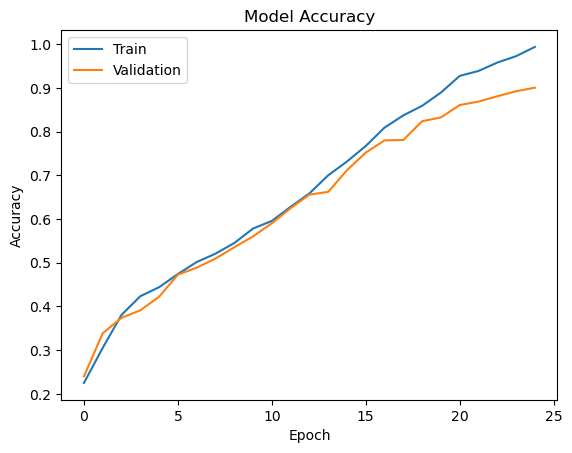

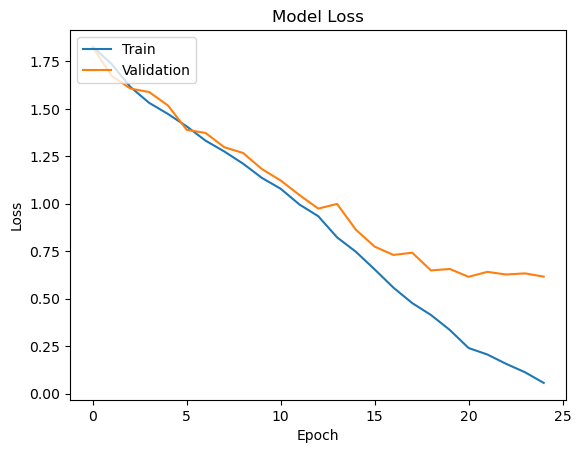

In [12]:
# laddar träningshistorik
with open('historyskarp3.pkl', 'rb') as file:
    historyskarp = pickle.load(file)

# Plottar  accuracy för träning och validering
plt.plot(historyskarp['accuracy'])
plt.plot(historyskarp['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(historyskarp['loss'])
plt.plot(historyskarp['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
#med denna kod för augmentation (att föra in noise för att höja generaliserbarheten)  så blev resultatet i den original modellen
#med 2potensökande nodantal 32-64-128 betydligt långsammare till resultat plot ses nedan och med samma epoker(25) så uppnås 
# endast val accuracy runt 0,45. Så det kan om möjligt vara en bättre modell efter lång träning men om datorkraft också vägs
# in och minimeras så är det inte den enklaste modellen för att lösa problemet med rimlig validation accuracy (>0,85)
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

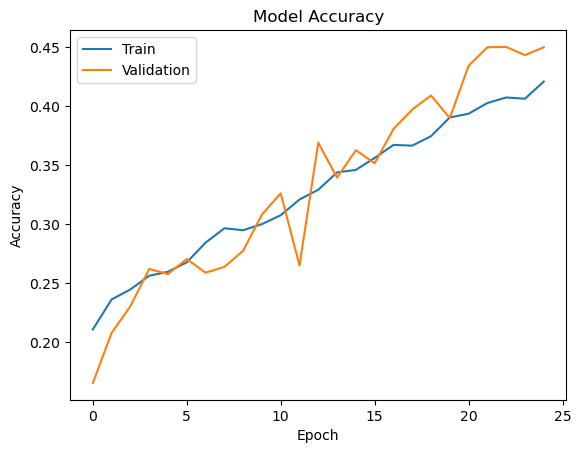

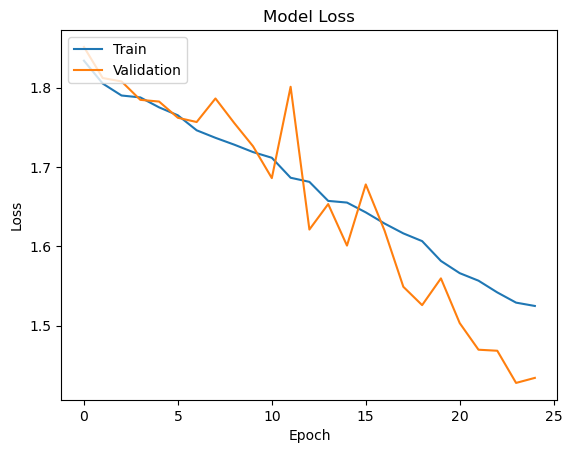

In [1]:
# Plottar för den dataaugmenterade modellen (augmentation ovan) som synes ingen förbättring med kort träning som förhandskrav.

# ladda träningshistoriken
with open('historyskarpaugmentation.pkl', 'rb') as file:
    historyskarp = pickle.load(file)

# Plot accuracy för träning mot validering
plt.plot(historyskarp['accuracy'])
plt.plot(historyskarp['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss 
plt.plot(historyskarp['loss'])
plt.plot(historyskarp['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
